# 2장. 간단한 분류 알고리즘 훈련

**아래 링크를 통해 이 노트북을 주피터 노트북 뷰어(nbviewer.jupyter.org)로 보거나 구글 코랩(colab.research.google.com)에서 실행할 수 있습니다.**

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://nbviewer.jupyter.org/github/rickiepark/python-machine-learning-book-2nd-edition/blob/master/code/ch02/ch02.ipynb"><img src="https://jupyter.org/assets/main-logo.svg" width="28" />주피터 노트북 뷰어로 보기</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/rickiepark/python-machine-learning-book-2nd-edition/blob/master/code/ch02/ch02.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />구글 코랩(Colab)에서 실행하기</a>
  </td>
</table>

`watermark`는 주피터 노트북에 사용하는 파이썬 패키지를 출력하기 위한 유틸리티입니다. `watermark` 패키지를 설치하려면 다음 셀의 주석을 제거한 뒤 실행하세요.

In [ ]:
#!pip install watermark

In [1]:
%load_ext watermark
%watermark -u -d -p numpy,pandas,matplotlib

last updated: 2019-04-25 

numpy 1.16.3
pandas 0.24.2
matplotlib 3.0.3


## 2.1 인공 뉴런: 초기 머신 러닝의 간단한 역사

### 인공 뉴런의 수학적 정의
- 1943년 워런 맥컬록 & 월터 피츠 간소화된 뇌 뉴런 개념을 발표 (맥컬룩-피츠 뉴런)
    - 신경 세포를 이진 출력을 내는 간단한 논리 회로로 표현
- 몇 년 후, 피랑크 로젠블라트 MCP 뉴런 모델 기반으로 퍼셉트론 학습 개념 발표
    - 자동으로 최적의 가중치를 학습하는 알고리즘 제안 (뉴런의 춝력 신호를 낼지 말지를 결정하기 위해 입력 특성에 곱하는 계수)
    
인공 뉴런 아이디어를 두 개의 클래스가 있는 이진 분류 작업으로 보면

- 두 클래스 1,-1
- x : 입력 값
- w : 가중치 <- 음수 임계 값 또는 가중치 $w_o=-θ$를 절편이라고 한다.
- 결정함수 : ∅(⋅) <- 단위 계단 함수
- 최종 입력 : z ($z = $$w^t$$x$)

### 퍼셉트론 학습 규칙

MCP 뉴런과 로젠블라트의 임계 퍼셉트론 모델 이면에 있는 전반적인 아이디어는 뇌의 뉴런 하나가 작동하는 방식을 흉내 내려는 환원주의 접근 방식을 사용한 것이다. (출력을 내거나 내지 않는 두 가지 경우만 있다.)

<퍼셉트론 학습규칙>
1. 가중치를 0 또는 랜덤한 작은 값으로 초기화한다.
2. 각 훈련 샘플 $x^{(i)}$에서 다음 작업을 한다
    - 출력 값 $\widehat{y}$를 계산한다. (출력 값 : 단위 계단 함수로 예측한 클래스 레이블)
    - 가중치를 업데이트한다.


- $w_j :=w_j+Δw_j$ : 가중치 벡터 $w$에 있는 개별 가중치 $w_j$가 동시에 업데이트
- $Δw_j=η(y^{(i)}-\widehat{y}^{(i)})x_j^{(i)}$, $0<η<1$ (퍼셉트론 학습 규칙에 따라 계산)
- $η$ : 학습률, $y^{(i)}$ : 진짜 클래스 레이블, $\widehat{y}^{(i)}$ : 예측 클래스 레이블
(모든 가중치 $Δw_j$를 업데이트 하기 전에 $\widehat{y}^{(i)}$를 다시 계산하지 않음)


퍼셉트론은 두 클래스가 선형적으로 구분되고 학습률이 충분히 작을 때만 수렴이 보장된다. 두 클래스를 선형 결정 경계로 나눌 수 없다면 훈련 데이터 셋을 반복할 최대 횟수(에포크)를 지정하고 분류 허용 오차를 지정할 수 있다.

## 2.2 파이썬으로 퍼셉트론 학습 알고리즘 구현하기

### 객체 지향 퍼셉트론 API

In [2]:
import numpy as np


class Perceptron(object):
    """퍼셉트론 분류기

    매개변수
    ------------
    eta : float
      학습률 (0.0과 1.0 사이)
    n_iter : int
      훈련 데이터셋 반복 횟수 (에포크 횟수)
    random_state : int
      가중치 무작위 초기화를 위한 난수 생성기 시드

    속성
    -----------
    w_ : 1d-array
      학습된 가중치
    errors_ : list
      에포크마다 누적된 분류 오류

    """
    def __init__(self, eta=0.01, n_iter=50, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state

    def fit(self, X, y): # 가중치 초기화 후 퍼셉트론 학습 규칙에 따라 가중치 업데이트
        """훈련 데이터 학습

        매개변수
        ----------
        X : {array-like}, shape = [n_samples, n_features]
          n_samples개의 샘플과 n_features개의 특성으로 이루어진 훈련 데이터
        y : array-like, shape = [n_samples]
          타깃값

        반환값
        -------
        self : object

        """
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=1 + X.shape[1]) #표준편차가 0.01인 정규 분포에서 난수 추출
        self.errors_ = []

        for _ in range(self.n_iter):
            errors = 0
            for xi, target in zip(X, y):
                update = self.eta * (target - self.predict(xi))
                self.w_[1:] += update * xi
                self.w_[0] += update
                errors += int(update != 0.0) # 가중치가 0이 아니여야 학습률이 분류 결과에 영향을 줌 (아니면 크기만 영향)
            self.errors_.append(errors) # 에포크마다 오분류 횟수 기록
        return self

    def net_input(self, X):
        """최종 입력 계산"""
        return np.dot(X, self.w_[1:]) + self.w_[0] #np.dot(X, self.w_[1:]) : w^t*x 계산

    def predict(self, X):
        """단위 계단 함수를 사용하여 클래스 레이블을 반환합니다"""
        return np.where(self.net_input(X) >= 0.0, 1, -1)

In [3]:
# 삼각법
v1 = np.array([1, 2, 3])
v2 = 0.5 * v1
np.arccos(v1.dot(v2) / (np.linalg.norm(v1) * np.linalg.norm(v2)))
# np.arccos : 역코사인 삼각 함수
# np.linalg.norm : 벡터 길이 계산

0.0

### 붓꽃 데이터셋에서 퍼셉트론 훈련

퍼셉트론 알고리즘은 다중 클래스 분류로 확장 가능 (일대다 전략). 여기선 시각화를 위하여 2차원을 사용

In [4]:
import pandas as pd

df = pd.read_csv('https://archive.ics.uci.edu/ml/'
        'machine-learning-databases/iris/iris.data', header=None)
df.tail()

0    1    2    3               4
145  6.7  3.0  5.2  2.3  Iris-virginica
146  6.3  2.5  5.0  1.9  Iris-virginica
147  6.5  3.0  5.2  2.0  Iris-virginica
148  6.2  3.4  5.4  2.3  Iris-virginica
149  5.9  3.0  5.1  1.8  Iris-virginica

### 노트:

이 깃허브에는 붓꽃 데이터셋이 포함되어 있습니다(이 책에서 사용하는 다른 데이터셋도 모두 포함되어 있습니다). 인터넷에 연결되어 있지 않거나 이따금 UCI 서버(https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data)에 접근할 수 없을 때 사용할 수 있습니다. 이런 경우 로컬 디렉터리에서 붓꽃 데이터를 로드하려면 다음 코드를
```python
    df = pd.read_csv('https://archive.ics.uci.edu/ml/'
        'machine-learning-databases/iris/iris.data', header=None)
```
다음과 같이 바꿉니다.
```python 
    df = pd.read_csv('your/local/path/to/iris.data', header=None)
```

### 붓꽃 데이터 그래프 그리기

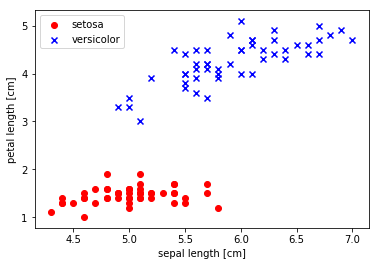

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

# setosa와 versicolor를 선택합니다
y = df.iloc[0:100, 4].values
y = np.where(y == 'Iris-setosa', -1, 1)

# 꽃받침 길이와 꽃잎 길이를 추출합니다
X = df.iloc[0:100, [0, 2]].values

# 산점도를 그립니다
plt.scatter(X[:50, 0], X[:50, 1],
            color='red', marker='o', label='setosa')
plt.scatter(X[50:100, 0], X[50:100, 1],
            color='blue', marker='x', label='versicolor')

plt.xlabel('sepal length [cm]')
plt.ylabel('petal length [cm]')
plt.legend(loc='upper left')

plt.show()

### 퍼셉트론 모델 훈련하기

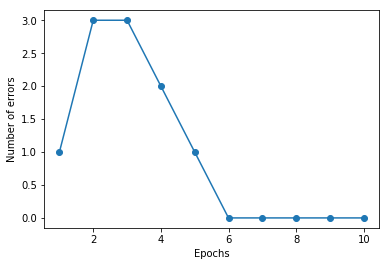

In [6]:
ppn = Perceptron(eta=0.1, n_iter=10)

ppn.fit(X, y)

plt.plot(range(1, len(ppn.errors_) + 1), ppn.errors_, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Number of errors')

plt.show()
# 에포크 대비 잘못 분류된 오차
# 6번째 에포크 이후 수렴

### 결정 경계 그래프 함수

In [7]:
from matplotlib.colors import ListedColormap # 컬러맵


def plot_decision_regions(X, y, classifier, resolution=0.02):

    # 마커와 컬러맵을 설정합니다
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # 결정 경계를 그립니다
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution)) # 그리드 배열 만듦
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T) #클래스 레이블 예측
    Z = Z.reshape(xx1.shape) # 동일한 차원의 그리도로 크기 변경
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # 샘플의 산점도를 그립니다
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.8, 
                    c=colors[idx],
                    marker=markers[idx], 
                    label=cl, 
                    edgecolor='black')

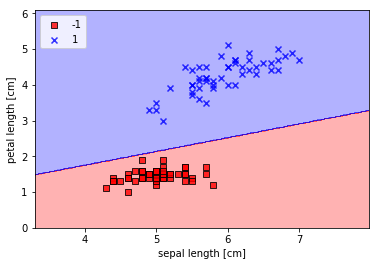

In [8]:
plot_decision_regions(X, y, classifier=ppn)
plt.xlabel('sepal length [cm]')
plt.ylabel('petal length [cm]')
plt.legend(loc='upper left')

plt.show()

## 2.3 적응형 선형 뉴런과 학습의 수렴

- 적응형 선형 뉴런
- 아달린 (퍼셉트론의 향상된 버전)
    - 연속 함수로 비용 함수를 정의하고 최소화
- 아달린 규칙과 퍼셉트론의 차이 : 가중치를 업데이트 하는 데 퍼셉트론 처럼 단위 계단 함수 대신 선형 활성화 함수를 사용
    - $∅(w^tx) = w^tx$ : 아달린에서 선형 활성화 함수는 최종 입력과 동일한 함수
    - 아달린 알고리즘 : 진짜 클래스 레이블과 선형 활성화 함수의 실수 출력 값을 비교하여 모델의 오차를 계산하고 가중치를 업데이트함
    - 퍼셉트론 : 진짜 클래스 레이블과 예측 클래스 레이블을 비교
    
### 경사 하강법으로 비용 함수 최소화
- 지도 학습 알고리즘의 핵심 구성요소는 학습 과정 동안 최적화 하기 위해 정의한 **목적 함수** (최소화하려는 비용함수가 목적함수가 됨)
- 아달린은 계산된 출력과 진짜 클래스 레이블 사이 **제곱 오차합(SSE)**으로 가중치를 학습할 비용함수 J를 정의
- 단위 계단 함수 대신 연속적인 선형 활성화 함수를 사용하여 비용 함수를 미분 가능하고 볼록 함수라는 특징을 사용하여 경사하강법 적용
- **경사 하강법**은 1차 근삿값 발견용 최적화 알고리즘이다. 함수의 기울기를 구하고 경사의 절댓값이 낮은 쪽으로 계속 이동시켜 극값에 이를 때까지 반복시키는 것이다.
![python image1](https://thebook.io/img/007022/p066.jpg)
- 아달린 학습 규칙은 퍼셉트론 규칙과 달리 실수이다. 그리고 훈련 세트에 있는 모든 샘플을 기반으로 가중치 업데이트를 계산한다.(**배치 경사 하강법**)

### 파이썬으로 아달린 구현하기

In [9]:
class AdalineGD(object):
    """적응형 선형 뉴런 분류기

    매개변수
    ------------
    eta : float
      학습률 (0.0과 1.0 사이)
    n_iter : int
      훈련 데이터셋 반복 횟수
    random_state : int
      가중치 무작위 초기화를 위한 난수 생성기 시드
    (eta과 n_iter은 퍼셉트론과 아달린 학습 알고리즘의 하이퍼파라미터)

    속성
    -----------
    w_ : 1d-array
      학습된 가중치
    cost_ : list
      에포크마다 누적된 비용 함수의 제곱합

    """
    def __init__(self, eta=0.01, n_iter=50, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state

    def fit(self, X, y):
        """훈련 데이터 학습

        매개변수
        ----------
        X : {array-like}, shape = [n_samples, n_features]
          n_samples 개의 샘플과 n_features 개의 특성으로 이루어진 훈련 데이터
        y : array-like, shape = [n_samples]
          타깃값

        반환값
        -------
        self : object

        """
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=1 + X.shape[1])
        self.cost_ = []

        for i in range(self.n_iter):
            net_input = self.net_input(X) # 전체 훈련 데이터 셋을 기반으로 그래디언트를 계산
            # Please note that the "activation" method has no effect
            # in the code since it is simply an identity function. We
            # could write `output = self.net_input(X)` directly instead.
            # The purpose of the activation is more conceptual, i.e.,  
            # in the case of logistic regression (as we will see later), 
            # we could change it to
            # a sigmoid function to implement a logistic regression classifier.
            output = self.activation(net_input)
            errors = (y - output)
            self.w_[1:] += self.eta * X.T.dot(errors) # 가중치 / X.T.dot(errors) : 특성 행렬과 오차 벡터 간의 행렬-벡터 곱셈
            self.w_[0] += self.eta * errors.sum() # 절편
            cost = (errors**2).sum() / 2.0
            self.cost_.append(cost)
        return self

    def net_input(self, X):
        """최종 입력 계산"""
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def activation(self, X):
        """선형 활성화 계산"""
        return X

    def predict(self, X):
        """단위 계단 함수를 사용하여 클래스 레이블을 반환합니다"""
        return np.where(self.activation(self.net_input(X)) >= 0.0, 1, -1)

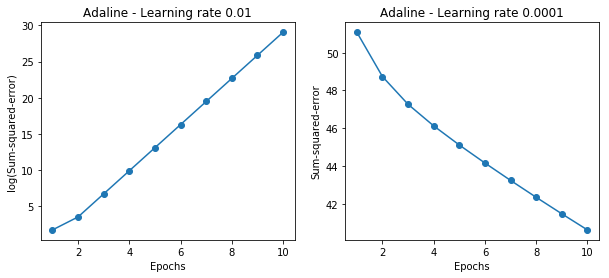

In [10]:
# 학습률 0.01과 0.0001의 에포크 횟수 대비 비용 그래프
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

ada1 = AdalineGD(n_iter=10, eta=0.01).fit(X, y)
ax[0].plot(range(1, len(ada1.cost_) + 1), np.log10(ada1.cost_), marker='o')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('log(Sum-squared-error)')
ax[0].set_title('Adaline - Learning rate 0.01')

ada2 = AdalineGD(n_iter=10, eta=0.0001).fit(X, y)
ax[1].plot(range(1, len(ada2.cost_) + 1), ada2.cost_, marker='o')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Sum-squared-error')
ax[1].set_title('Adaline - Learning rate 0.0001')

plt.show()

# 0.01일 때는 비용 함수 최소화하지 못하고 오차가 점점 커짐
# 0.0001일 때는 학습률이 너무 작아 아주 많은 에포크가 필요
# 너무 큰 학습률을 선택하면 전역 최솟값을 지나칠 수 있음, 적절한 학습률 선택이 중요

### 특성 스케일을 조정하여 경사 하강법 결과 향상시키기
- 표준화 : 각 특성의 평균을 0, 표준 편차를 1로 만듬
- 데이터에 표준 정규 분포의 성질을 부여하여 경사 하강법 학습이 좀더 빠르게 수렴되도록 도움

In [11]:
# 특성을 표준화합니다.
X_std = np.copy(X)
X_std[:, 0] = (X[:, 0] - X[:, 0].mean()) / X[:, 0].std()
X_std[:, 1] = (X[:, 1] - X[:, 1].mean()) / X[:, 1].std()

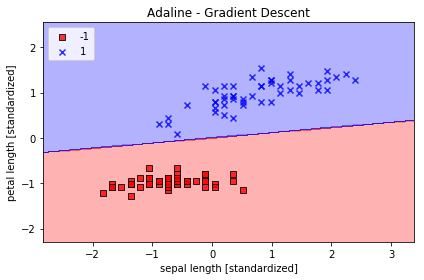

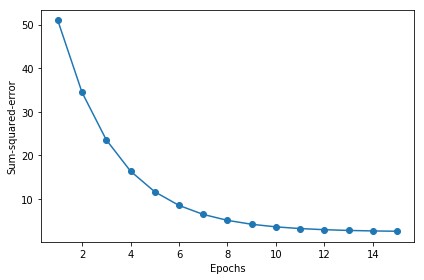

In [12]:
ada = AdalineGD(n_iter=15, eta=0.01)
ada.fit(X_std, y)

plot_decision_regions(X_std, y, classifier=ada)
plt.title('Adaline - Gradient Descent')
plt.xlabel('sepal length [standardized]')
plt.ylabel('petal length [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

plt.plot(range(1, len(ada.cost_) + 1), ada.cost_, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Sum-squared-error')

plt.tight_layout()
plt.show()
# 표준화 된 특성에서 학습률 0.01을 사용했을 때 아달린 모델이 수렴함 
# 모든 샘플이 완벽히 분류되도 SSE가 0은 아님

### 대규모 머신 러닝과 확률적 경사 하강법
- **배치 경사 하강법** : 전체 훈련 세트에서 계산한 그래디언트의 반대 방향으로 한 걸음씩 진행하여 비용 함수를 최소화 하는 방법
    - 이 방법은 매우 큰 데이터 셋에서 계산 비용이 매우 많이 발생 (전역 최솟값으로 가는 단계마다 매번 전체 훈련 데이터 셋을 재평가)
    
    
- **확률적 경사 하강법** : 모든 샘플에 대하여 누적된 오차의 합을 기반으로 가중치를 업데이트 하는 대신 각 훈련 샘플에 대해서 조금씩 가중치를 업데이트 
    - 경사 하강법의 근사로 생각할수 있음
    - 가중치가 더 자주 업데이트 되어 수렴 속도가 빠름
    - 그래디언트가 하나의 훈련 샘플을 기반으로 계산되므로 오차의 궤적은 배치 경사 하강법보다 훨씬 어지러움
    - 비선형 비용 함수를 다룰 때 얕은 지역 최솟값을 더 쉽게 탈출할 수 있음
    - 훈련 샘플 순서를 무작위하게 주입하고 에포크마다 훈련 세트를 섞어야(순환x) 만족스러운 결과를 얻을 수 있음
    - **온라인 학습**으로 사용가능

In [13]:
class AdalineSGD(object):
    """ADAptive LInear NEuron 분류기

    Parameters
    ------------
    eta : float
      학습률 (0.0과 1.0 사이)
    n_iter : int
      훈련 데이터셋 반복 횟수
    shuffle : bool (default: True)
      True로 설정하면 같은 반복이 되지 않도록 에포크마다 훈련 데이터를 섞습니다
    random_state : int
      가중치 무작위 초기화를 위한 난수 생성기 시드

    Attributes
    -----------
    w_ : 1d-array
      학습된 가중치
    cost_ : list
      모든 훈련 샘플에 대해 에포크마다 누적된 평균 비용 함수의 제곱합

    """
    def __init__(self, eta=0.01, n_iter=10, shuffle=True, random_state=None):
        self.eta = eta
        self.n_iter = n_iter
        self.w_initialized = False
        self.shuffle = shuffle
        self.random_state = random_state
        
    def fit(self, X, y):
        """훈련 데이터 학습

        Parameters
        ----------
        X : {array-like}, shape = [n_samples, n_features]
          n_samples 개의 샘플과 n_features 개의 특성으로 이루어진 훈련 데이터
        y : array-like, shape = [n_samples]
          타깃 벡터

        반환값
        -------
        self : object

        """
        self._initialize_weights(X.shape[1])
        self.cost_ = []
        for i in range(self.n_iter):
            if self.shuffle:
                X, y = self._shuffle(X, y)
            cost = []
            for xi, target in zip(X, y):
                cost.append(self._update_weights(xi, target))
            avg_cost = sum(cost) / len(y)
            self.cost_.append(avg_cost)
        return self

    def partial_fit(self, X, y):
        """가중치를 다시 초기화하지 않고 훈련 데이터를 학습합니다"""
        if not self.w_initialized:
            self._initialize_weights(X.shape[1])
        if y.ravel().shape[0] > 1:
            for xi, target in zip(X, y):
                self._update_weights(xi, target)
        else:
            self._update_weights(X, y)
        return self

    def _shuffle(self, X, y):
        """훈련 데이터를 섞습니다"""
        r = self.rgen.permutation(len(y))
        return X[r], y[r]
    
    def _initialize_weights(self, m):
        """랜덤한 작은 수로 가중치를 초기화합니다"""
        self.rgen = np.random.RandomState(self.random_state)
        self.w_ = self.rgen.normal(loc=0.0, scale=0.01, size=1 + m)
        self.w_initialized = True
        
    def _update_weights(self, xi, target):
        """아달린 학습 규칙을 적용하여 가중치를 업데이트합니다"""
        output = self.activation(self.net_input(xi))
        error = (target - output)
        self.w_[1:] += self.eta * xi.dot(error)
        self.w_[0] += self.eta * error
        cost = 0.5 * error**2
        return cost
    
    def net_input(self, X):
        """최종 입력 계산"""
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def activation(self, X):
        """선형 활성화 계산"""
        return X

    def predict(self, X):
        """단위 계단 함수를 사용하여 클래스 레이블을 반환합니다"""
        return np.where(self.activation(self.net_input(X)) >= 0.0, 1, -1)

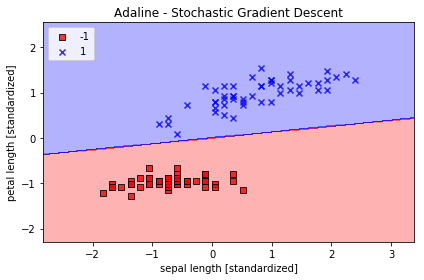

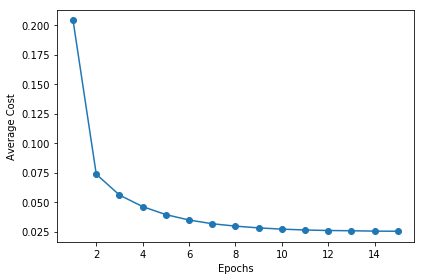

In [14]:
ada = AdalineSGD(n_iter=15, eta=0.01, random_state=1)
ada.fit(X_std, y)

plot_decision_regions(X_std, y, classifier=ada)
plt.title('Adaline - Stochastic Gradient Descent')
plt.xlabel('sepal length [standardized]')
plt.ylabel('petal length [standardized]')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

plt.plot(range(1, len(ada.cost_) + 1), ada.cost_, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Average Cost')

plt.tight_layout()
plt.show()
# 평균 비용이 상당히 빠르게 감소
# 15번째 에포크 이후 최종 결정 경계는 배치 경사 하강법과 비슷

스트리밍 데이터를 사용하는 온라인 학습 방식으로 모델을 훈련하려면 개개의 샘플마다 partial_fit 메서드를 호출하면 됨.
```python
ada.partial_fit(X_std[0,:], y[0])
```